In [1]:
!pip install git+https://github.com/messari/messari-python-api.git
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/messari/messari-python-api.git to /tmp/pip-req-build-srjkzclz
  Running command git clone --filter=blob:none --quiet https://github.com/messari/messari-python-api.git /tmp/pip-req-build-srjkzclz
  Resolved https://github.com/messari/messari-python-api.git to commit 79a204e6a12111402833287e4fdbdb088d22fa4a
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from messari.messari import Messari

messari = Messari()
assets = ['bitcoin']
metric = 'price'
start = '2020-01-01'
end = '2023-01-01'
df = messari.get_metric_timeseries(asset_slugs=assets, asset_metric=metric, start=start, end=end)
df = df[f'{assets[0]}']

In [3]:
dates = df.reset_index()['timestamp'].tolist()
close = df['close'].tolist()

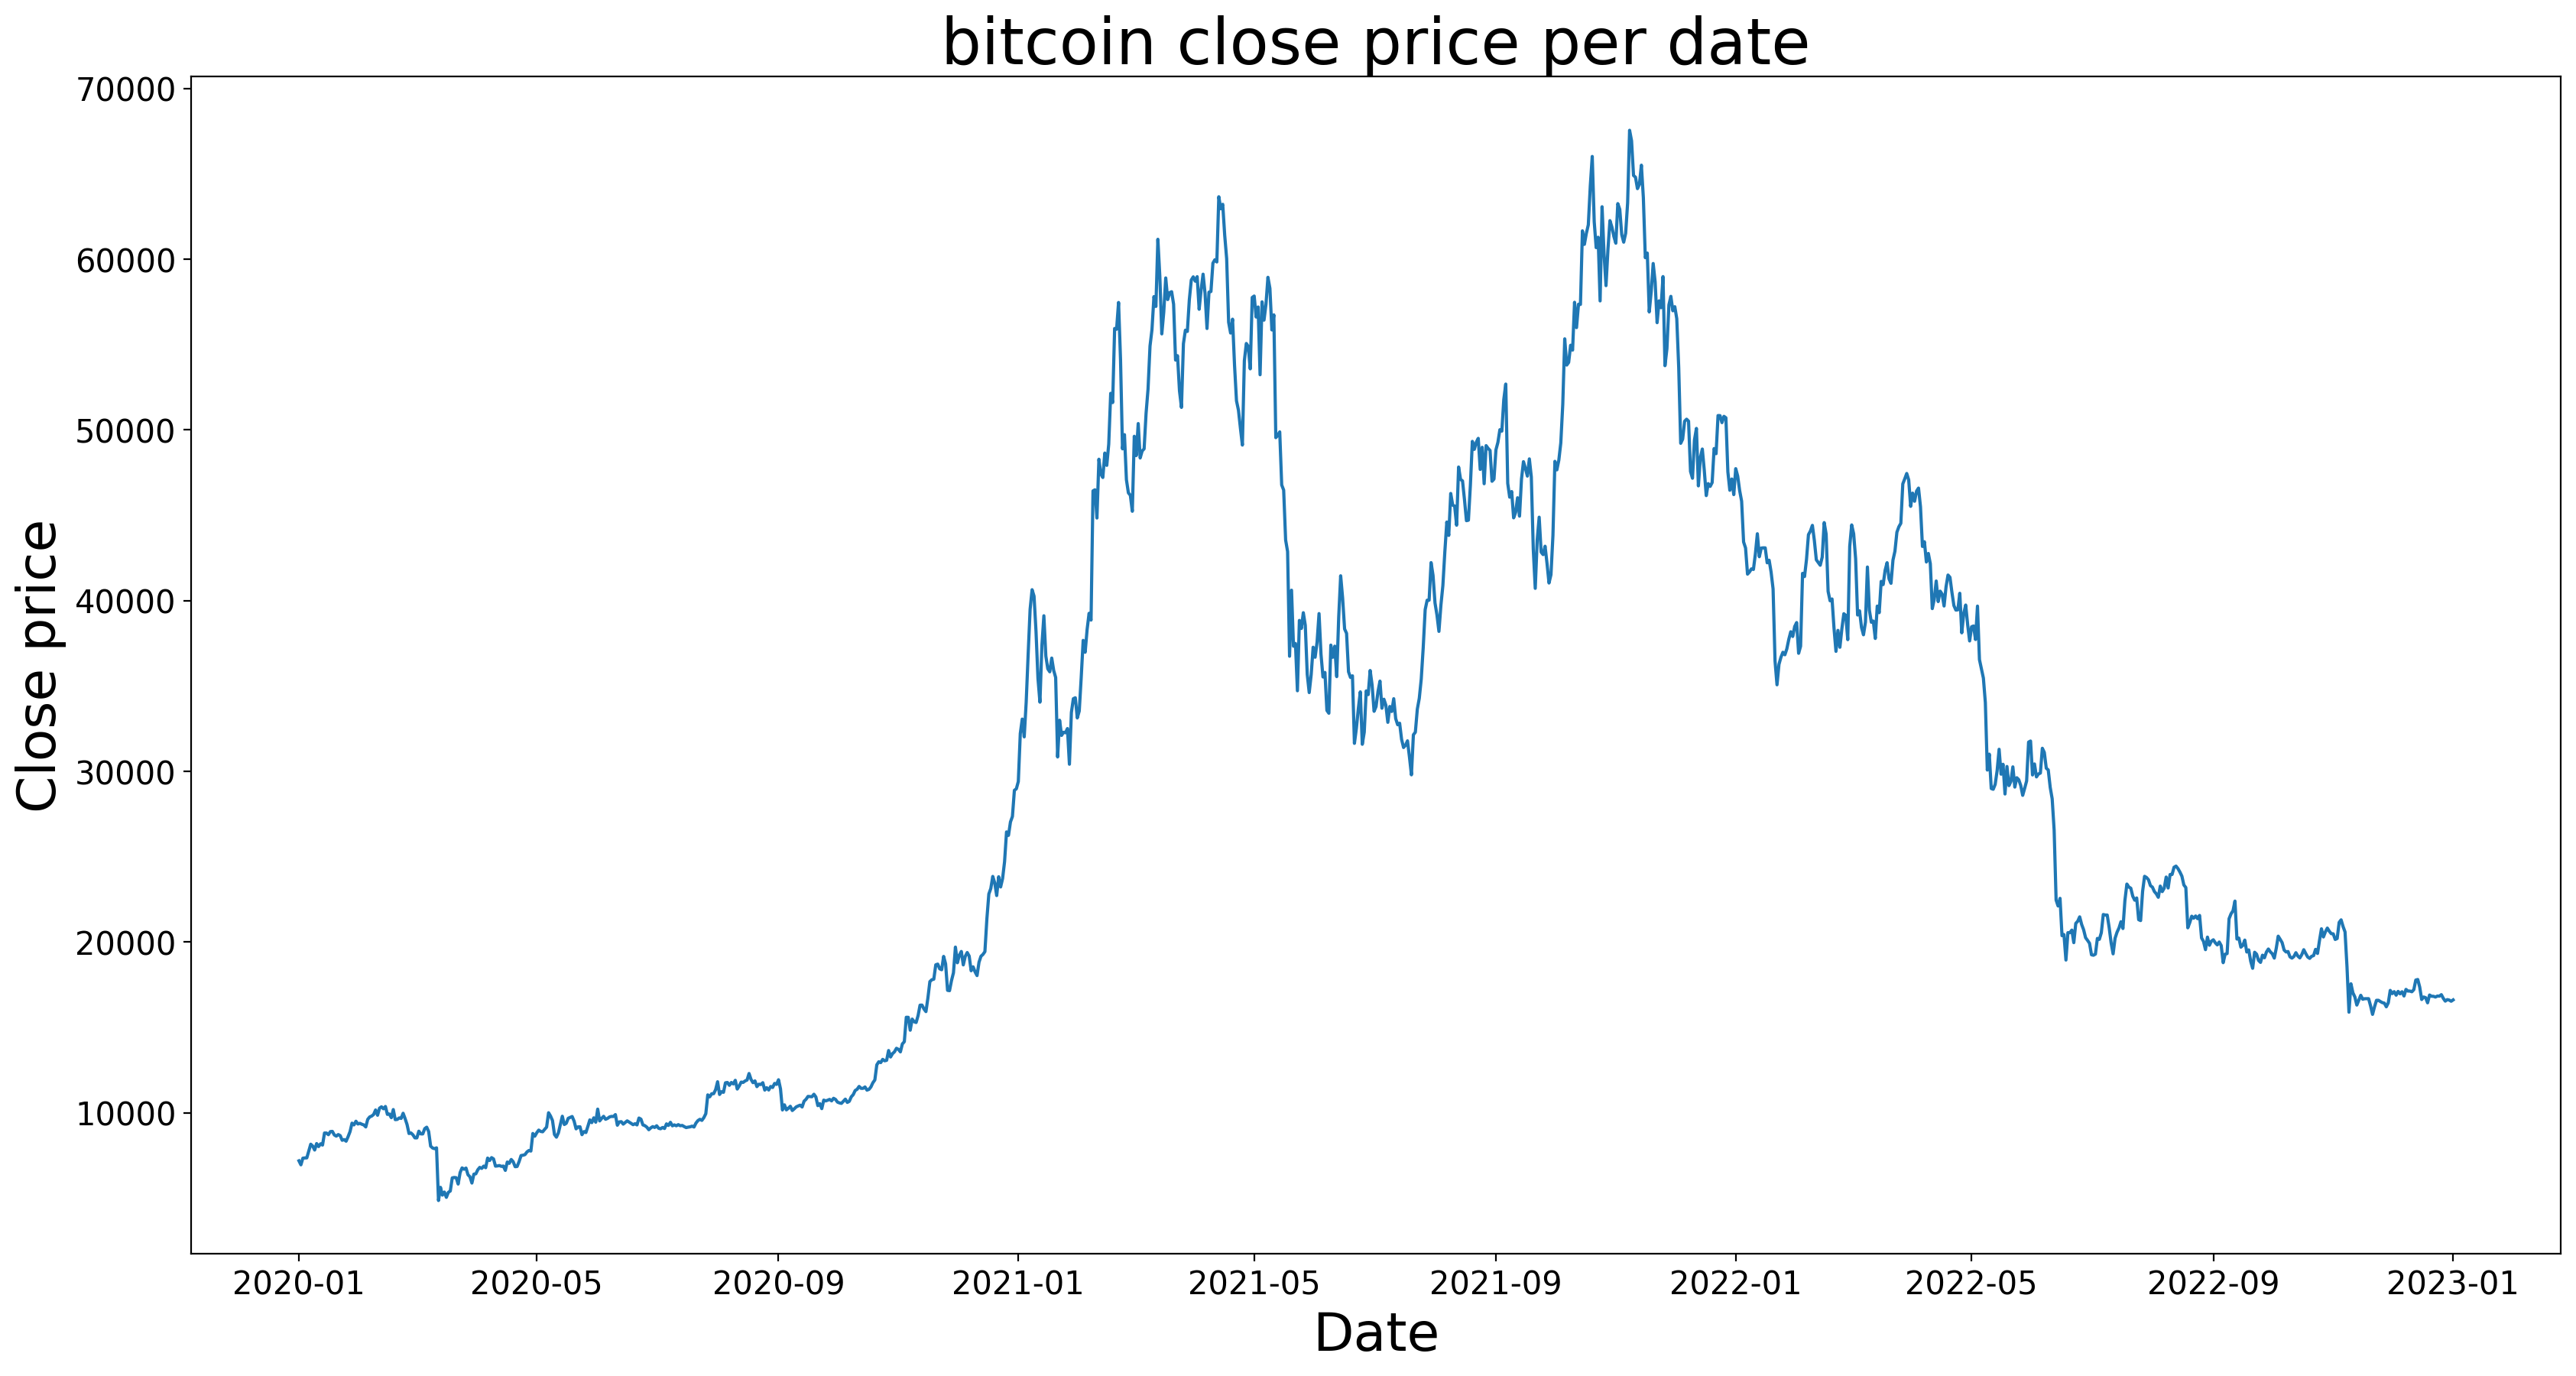

In [4]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10
plt.plot(dates, close)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.title(f"{assets[0]} close price per date", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split

period = 7
test = close[-period:]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(np.array(close[:-period]).reshape(-1, 1))
train, val = train_test_split(scaled_close, test_size=0.2, shuffle=False)

### Need to split sequences of train and test dset. ###

In [19]:
train_batch = 100

def create_sequences(dataset, train_batch):
    X_train, Y_train = [], []
    for i in range(len(dataset)-train_batch):
        X_train.append(dataset[i:(i+train_batch), 0])
        Y_train.append(dataset[i+train_batch, 0])
    return np.array(X_train), np.array(Y_train)

X_train, y_train = create_sequences(train, train_batch)
X_val, y_val = create_sequences(val, train_batch)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:", X_val.shape)
print("y_val", y_val.shape)

X_train: (772, 100, 1)
y_train: (772,)
X_val: (118, 100, 1)
y_val (118,)


In [20]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(200, return_sequences=True, input_shape=(None, 1), activation="relu"))
model.add(Dropout(0.2))
model.add(LSTM(200, return_sequences=False, input_shape=(None, 1), activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=300, batch_size=64, verbose=1)

Epoch 1/300
13/13 [==============================] - 9s 328ms/step - loss: 0.0864 - val_loss: 3.5250e-04
Epoch 2/300
13/13 [==============================] - 4s 306ms/step - loss: 0.0106 - val_loss: 4.6872e-04
Epoch 3/300
13/13 [==============================] - 5s 409ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 4/300
13/13 [==============================] - 4s 304ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 5/300
13/13 [==============================] - 4s 341ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/300
13/13 [==============================] - 5s 336ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 7/300
13/13 [==============================] - 4s 303ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 8/300
13/13 [==============================] - 6s 435ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 9/300
13/13 [==============================] - 4s 298ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 10/300
13/13 [==============================] - 4s 303ms/step - loss: 0.0026 

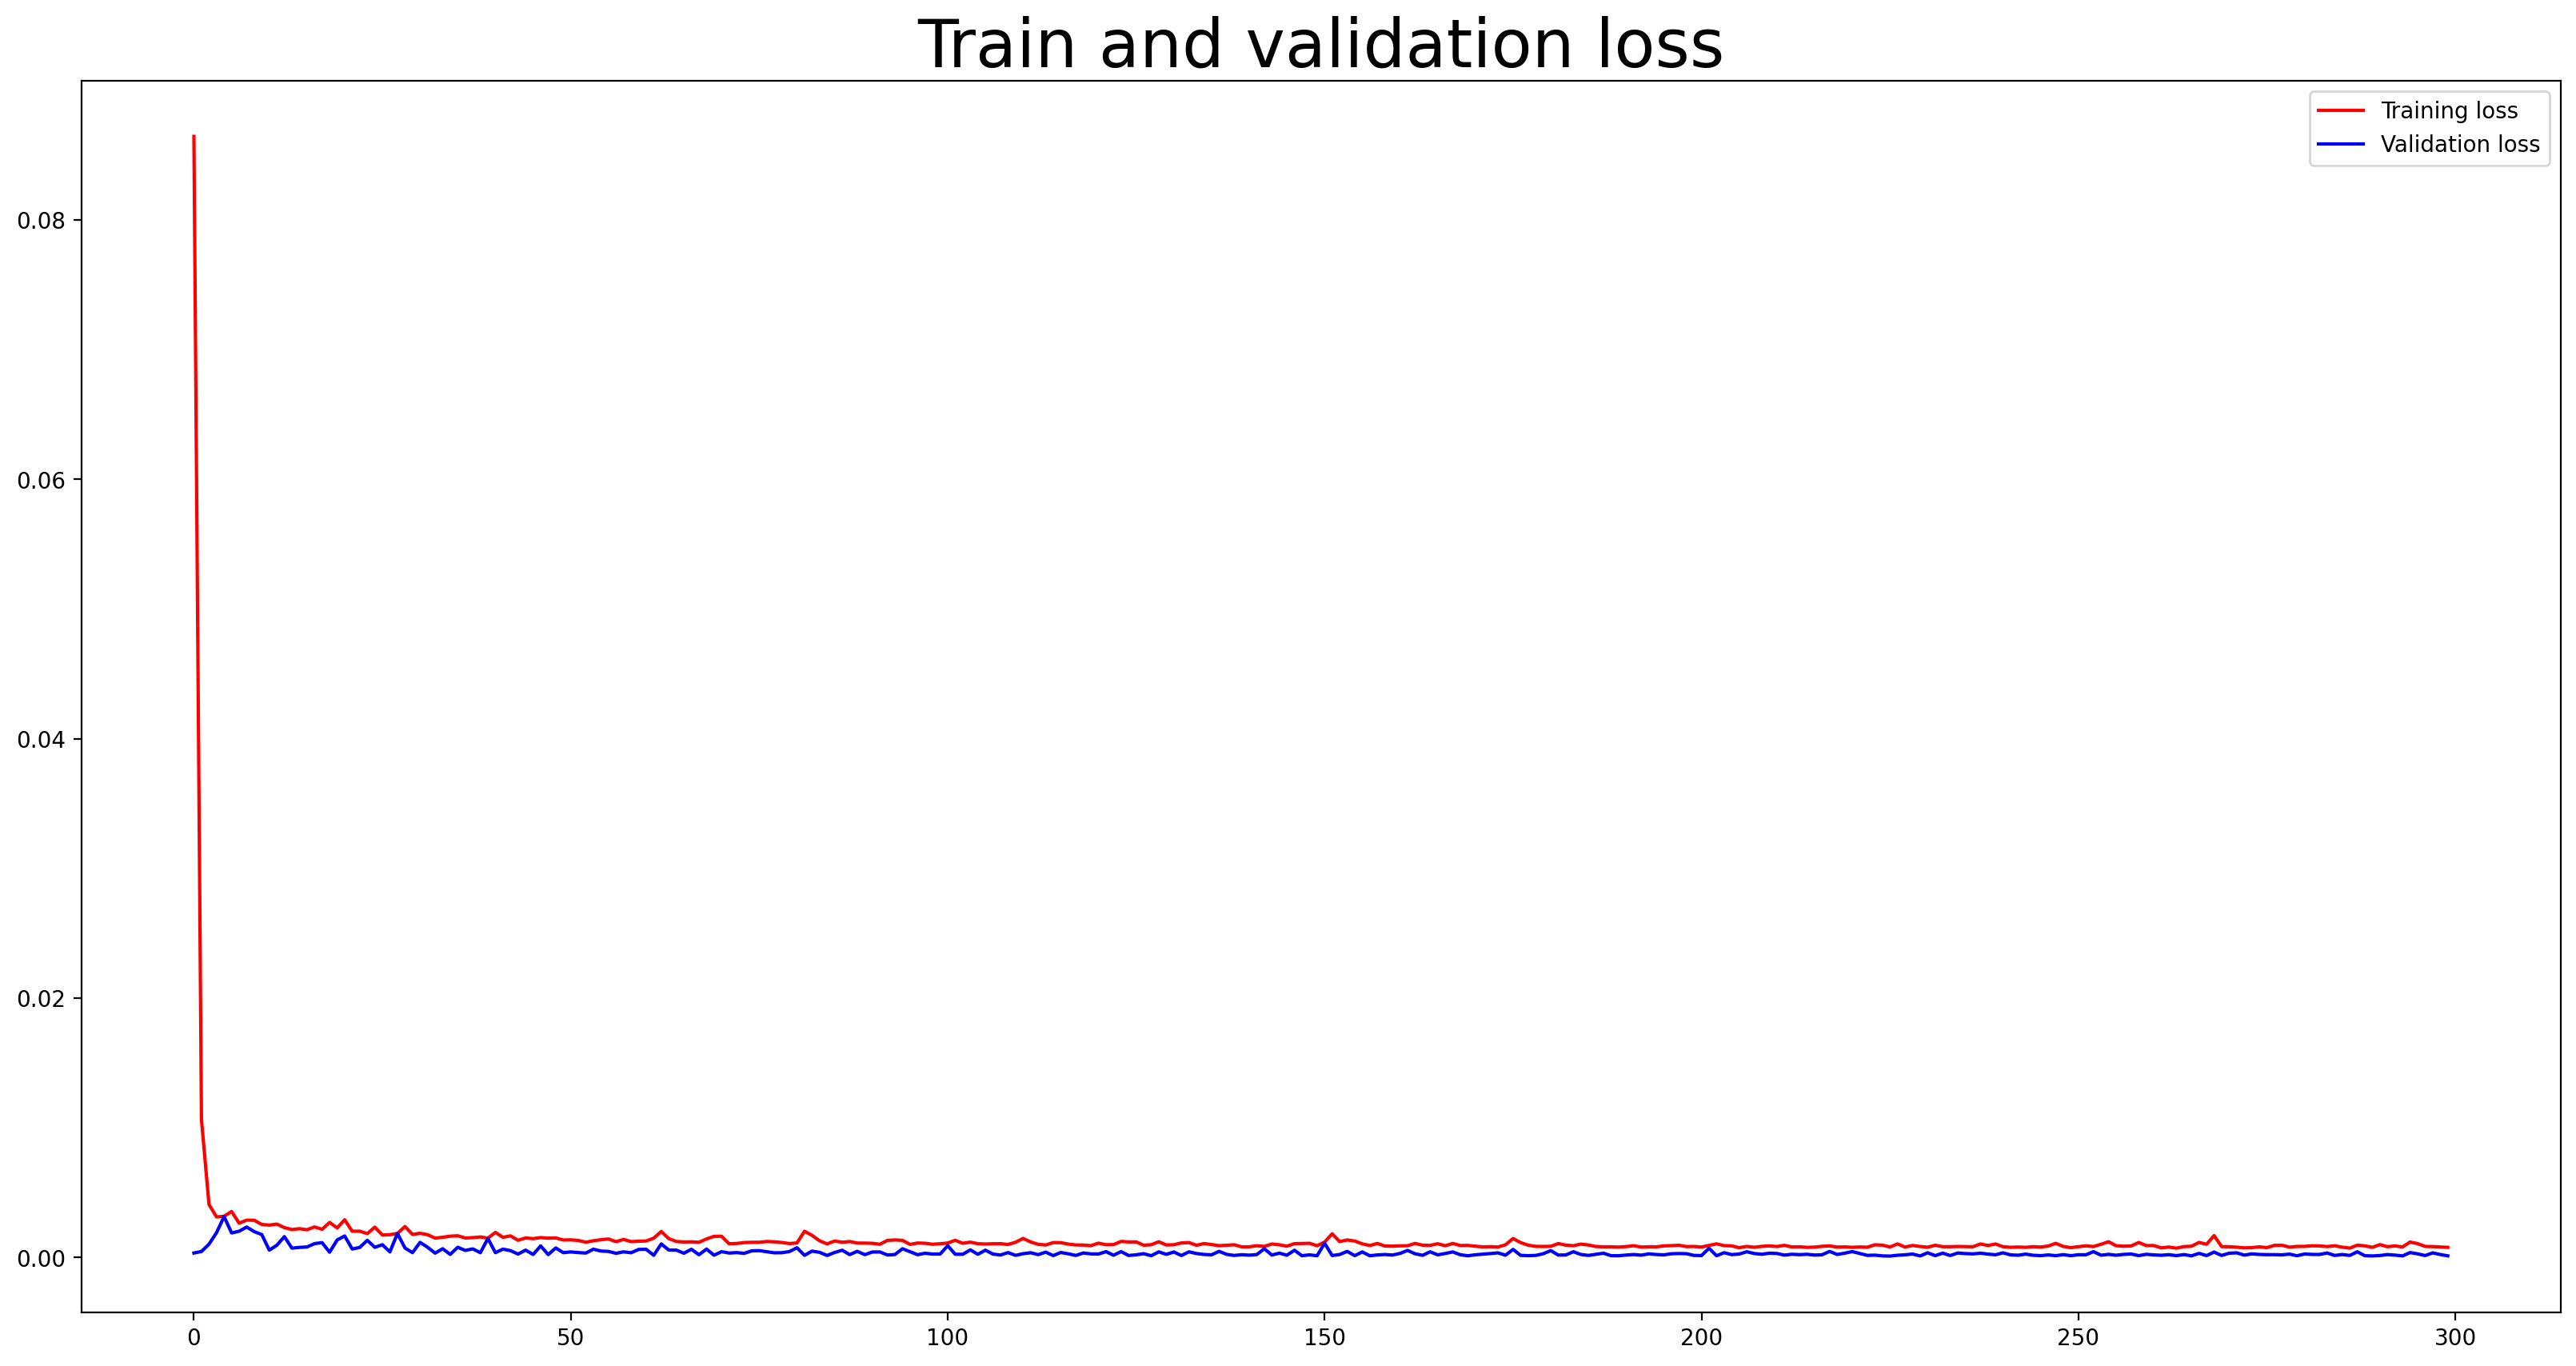

In [22]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='blue', label='Validation loss')
plt.title('Train and validation loss', fontsize = 30)
plt.legend()


plt.show()

In [23]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
train_pred = scaler.inverse_transform(train_pred)
val_pred = scaler.inverse_transform(val_pred)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_yval = scaler.inverse_transform(y_val.reshape(-1,1))

4/4 [==============================] - 0s 54ms/step


In [24]:
from sklearn.metrics import mean_squared_error

print("Train RMSE: %.3f" % mean_squared_error(original_ytrain, train_pred, squared=False))
print("Val RMSE: %.3f" % mean_squared_error(original_yval, val_pred, squared=False))

Train RMSE: 1687.641
Val RMSE: 723.658


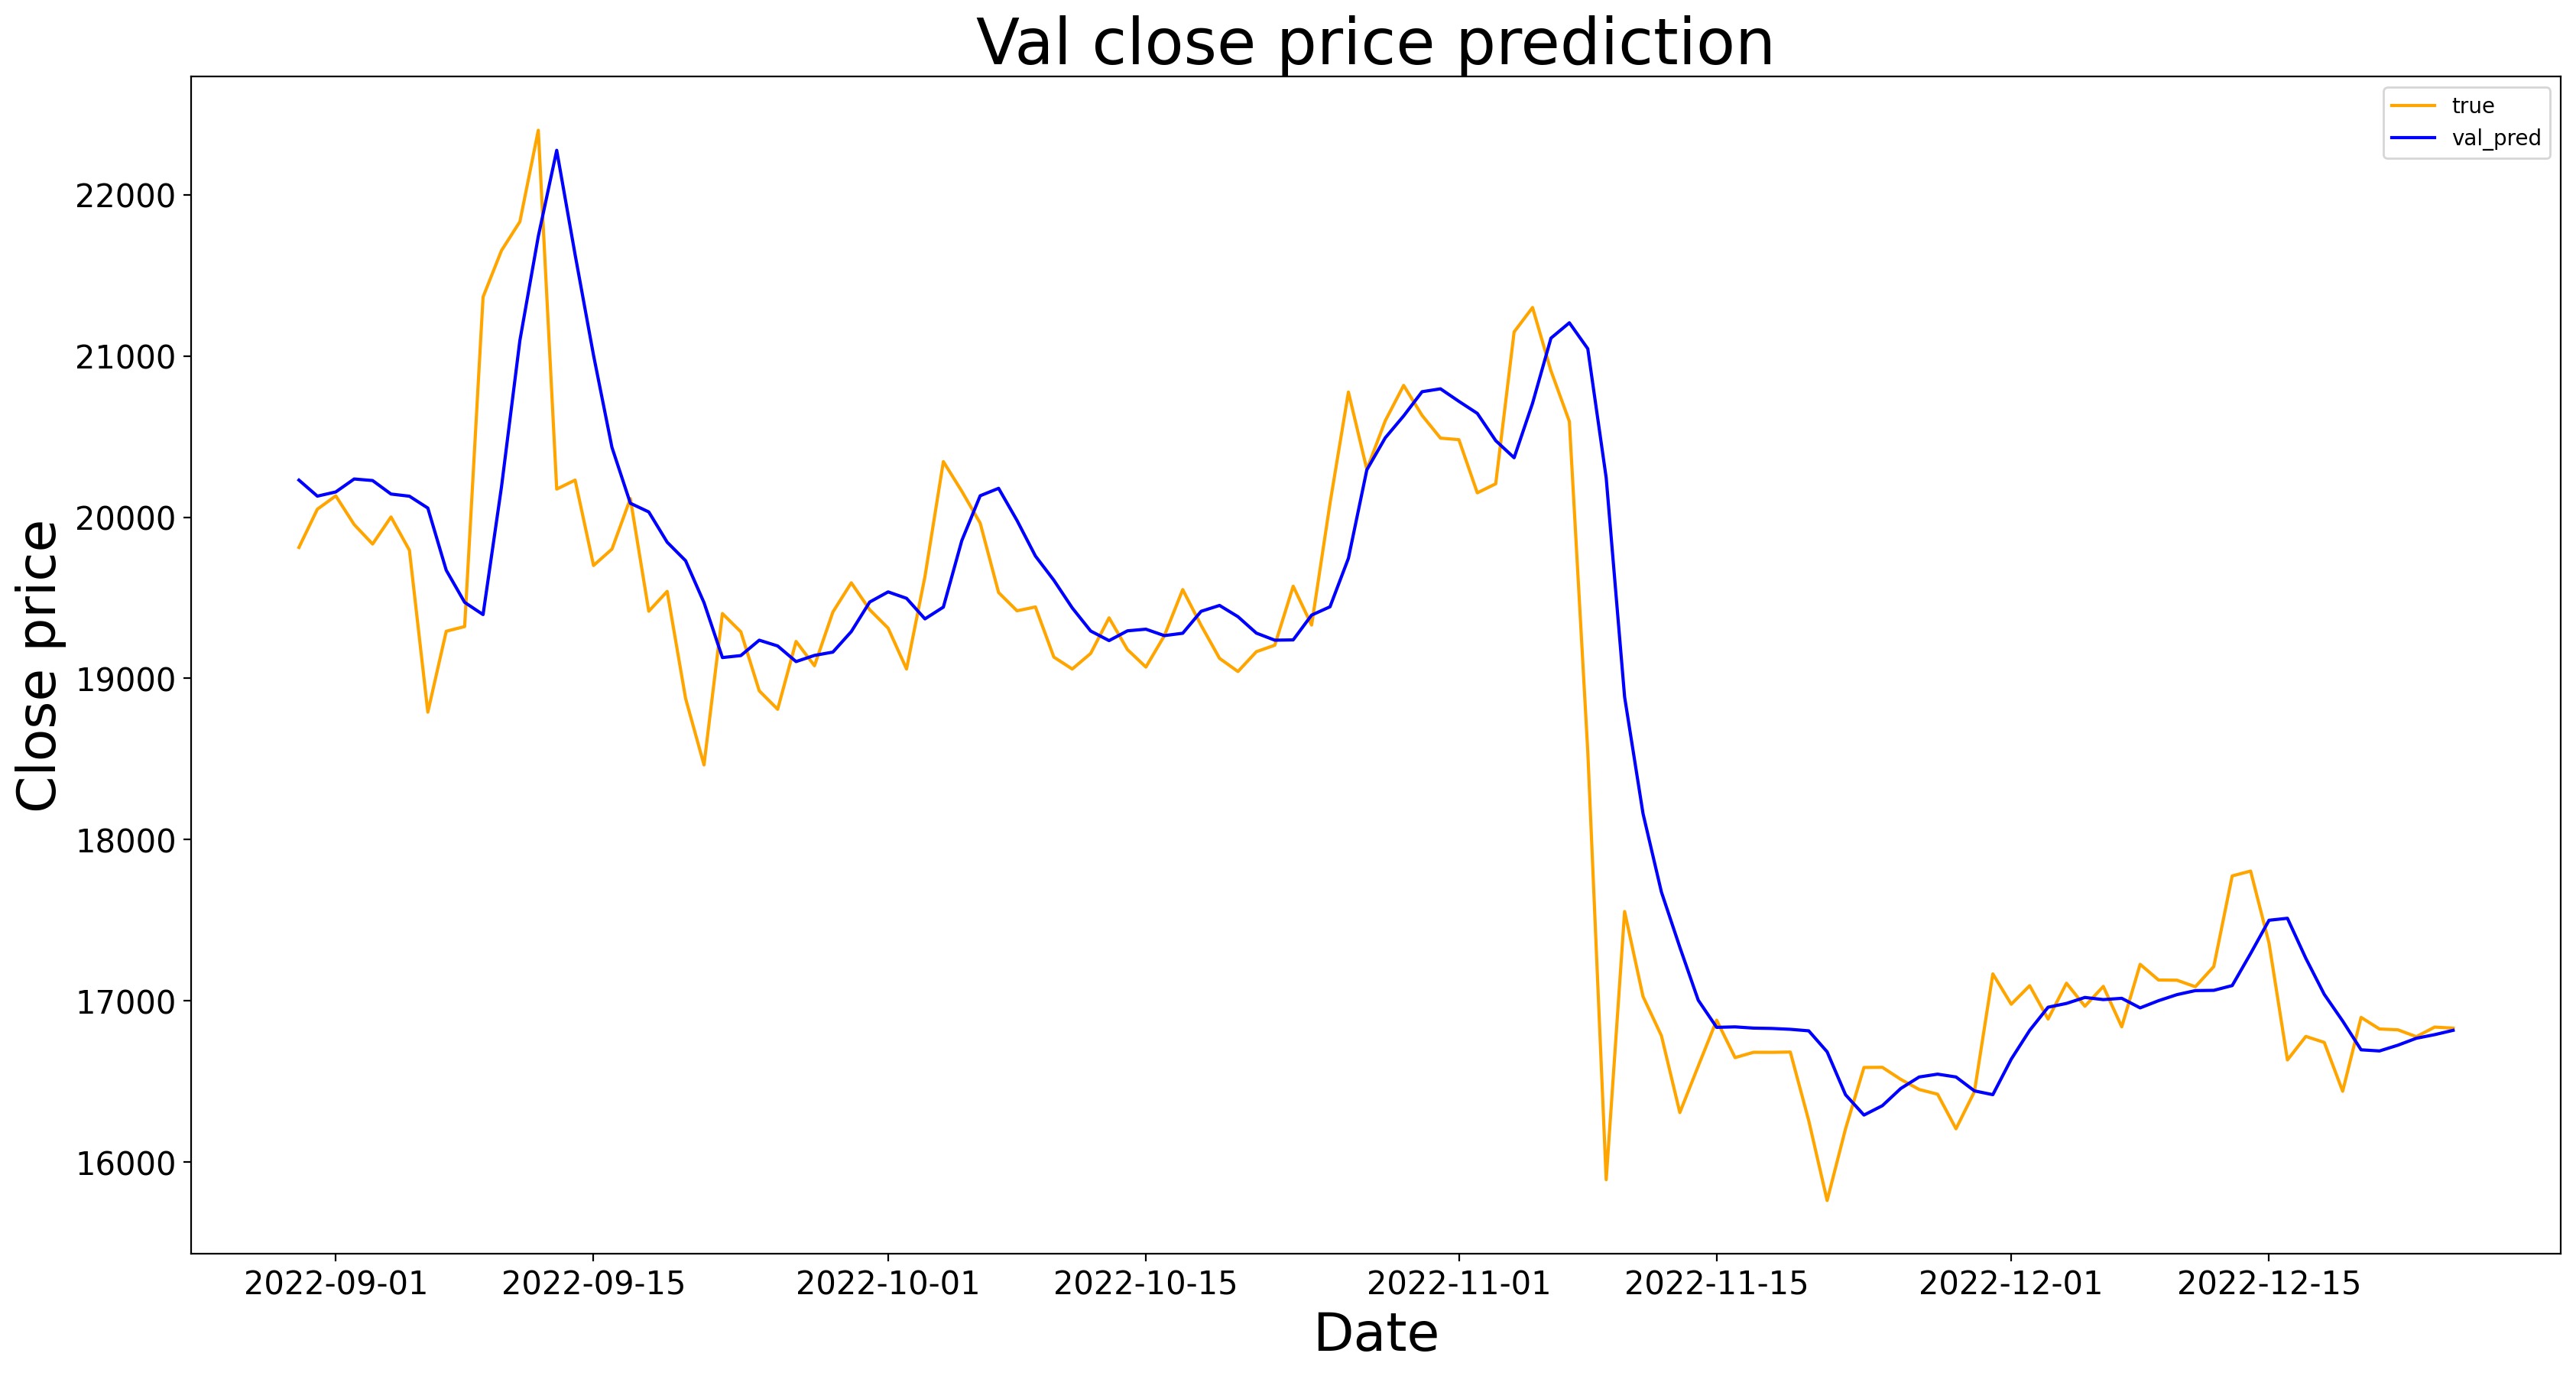

In [25]:
plt.title("Val close price prediction", fontsize = 30)
plt.plot(dates[2*train_batch+len(train_pred):-period], close[2*train_batch+len(train_pred):-period], color = 'orange', label = 'true')
plt.plot(dates[2*train_batch+len(train_pred):-period], val_pred, color = 'blue', label = 'val_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

In [26]:
X_train = scaled_close[-train_batch:].reshape(1, train_batch, 1)
test_pred = []
for i in range(period):
    next_pred = model.predict(X_train, verbose=0)
    X_train = X_train.reshape(X_train.shape[1])[1:]
    X_train = np.append(X_train, next_pred)
    X_train = X_train.reshape(1, train_batch, 1)
    test_pred.append(next_pred[0][0])

test_pred = scaler.inverse_transform(np.array(test_pred).reshape(-1, 1)).reshape(period)
test_pred

array([16598.418, 16600.406, 16606.014, 16612.535, 16618.877, 16624.58 ,
       16629.436], dtype=float32)

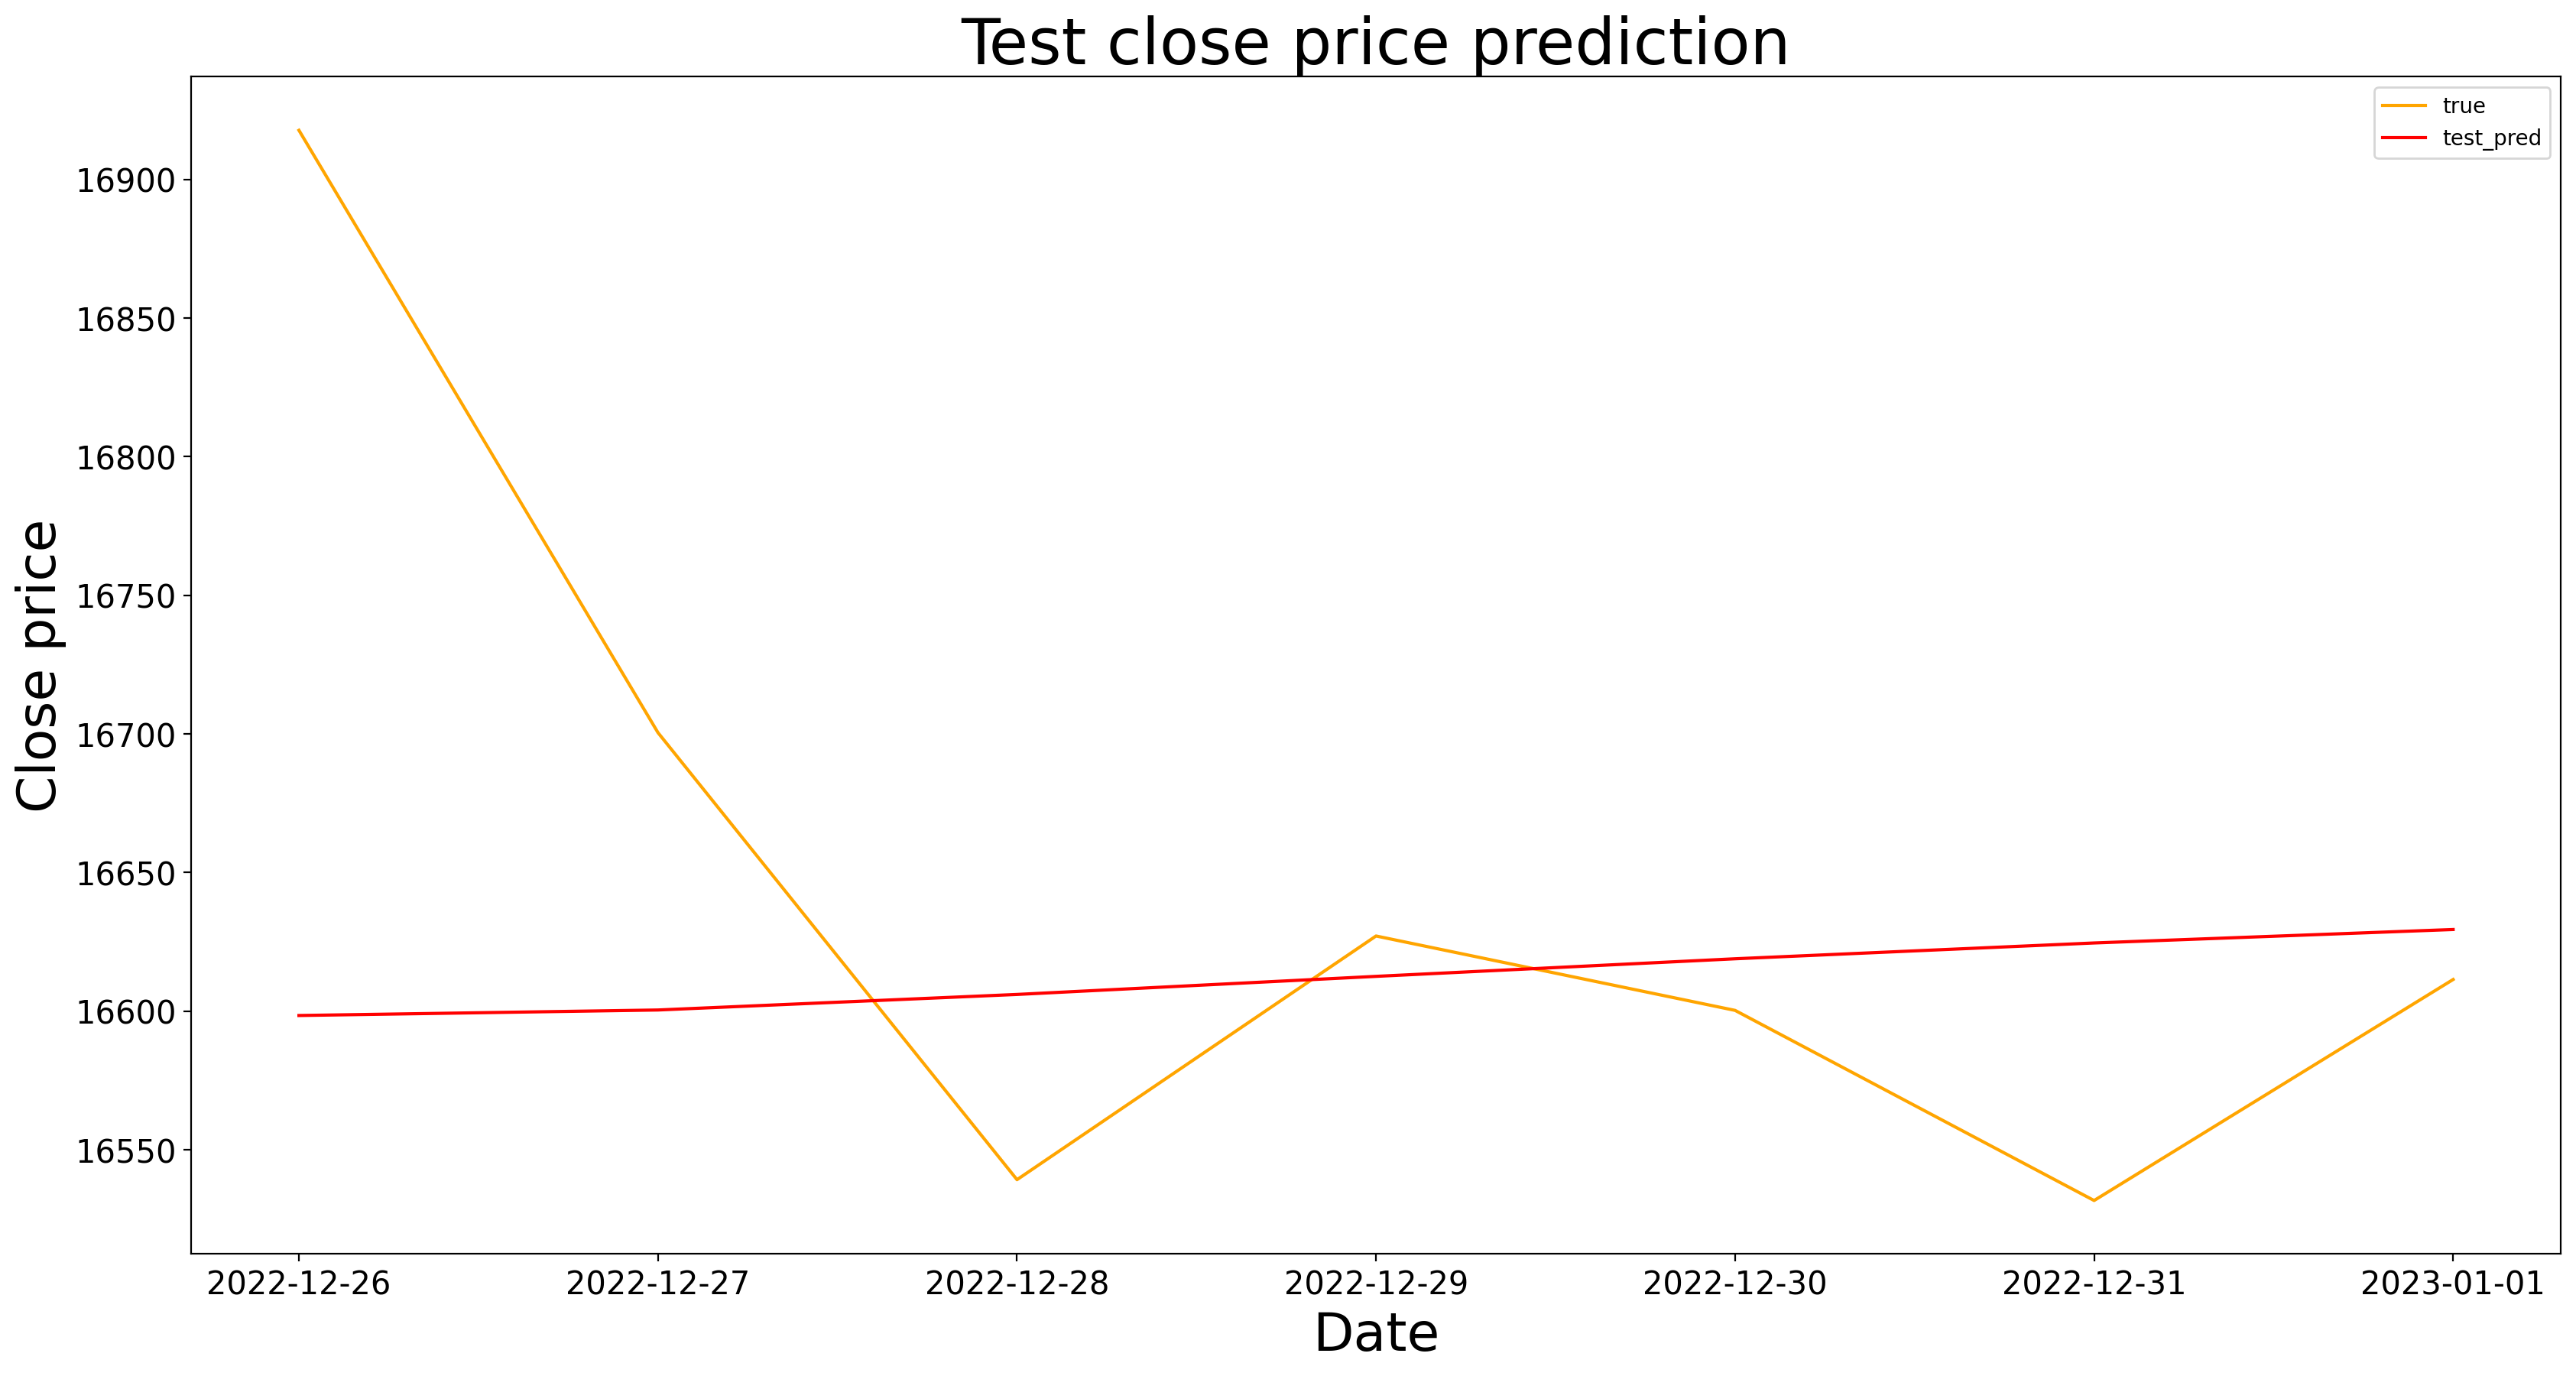

In [27]:
plt.title("Test close price prediction", fontsize = 30)
plt.plot(dates[-period:], test, color = 'orange', label = 'true')
plt.plot(dates[-period:], test_pred, color = 'red', label = 'test_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

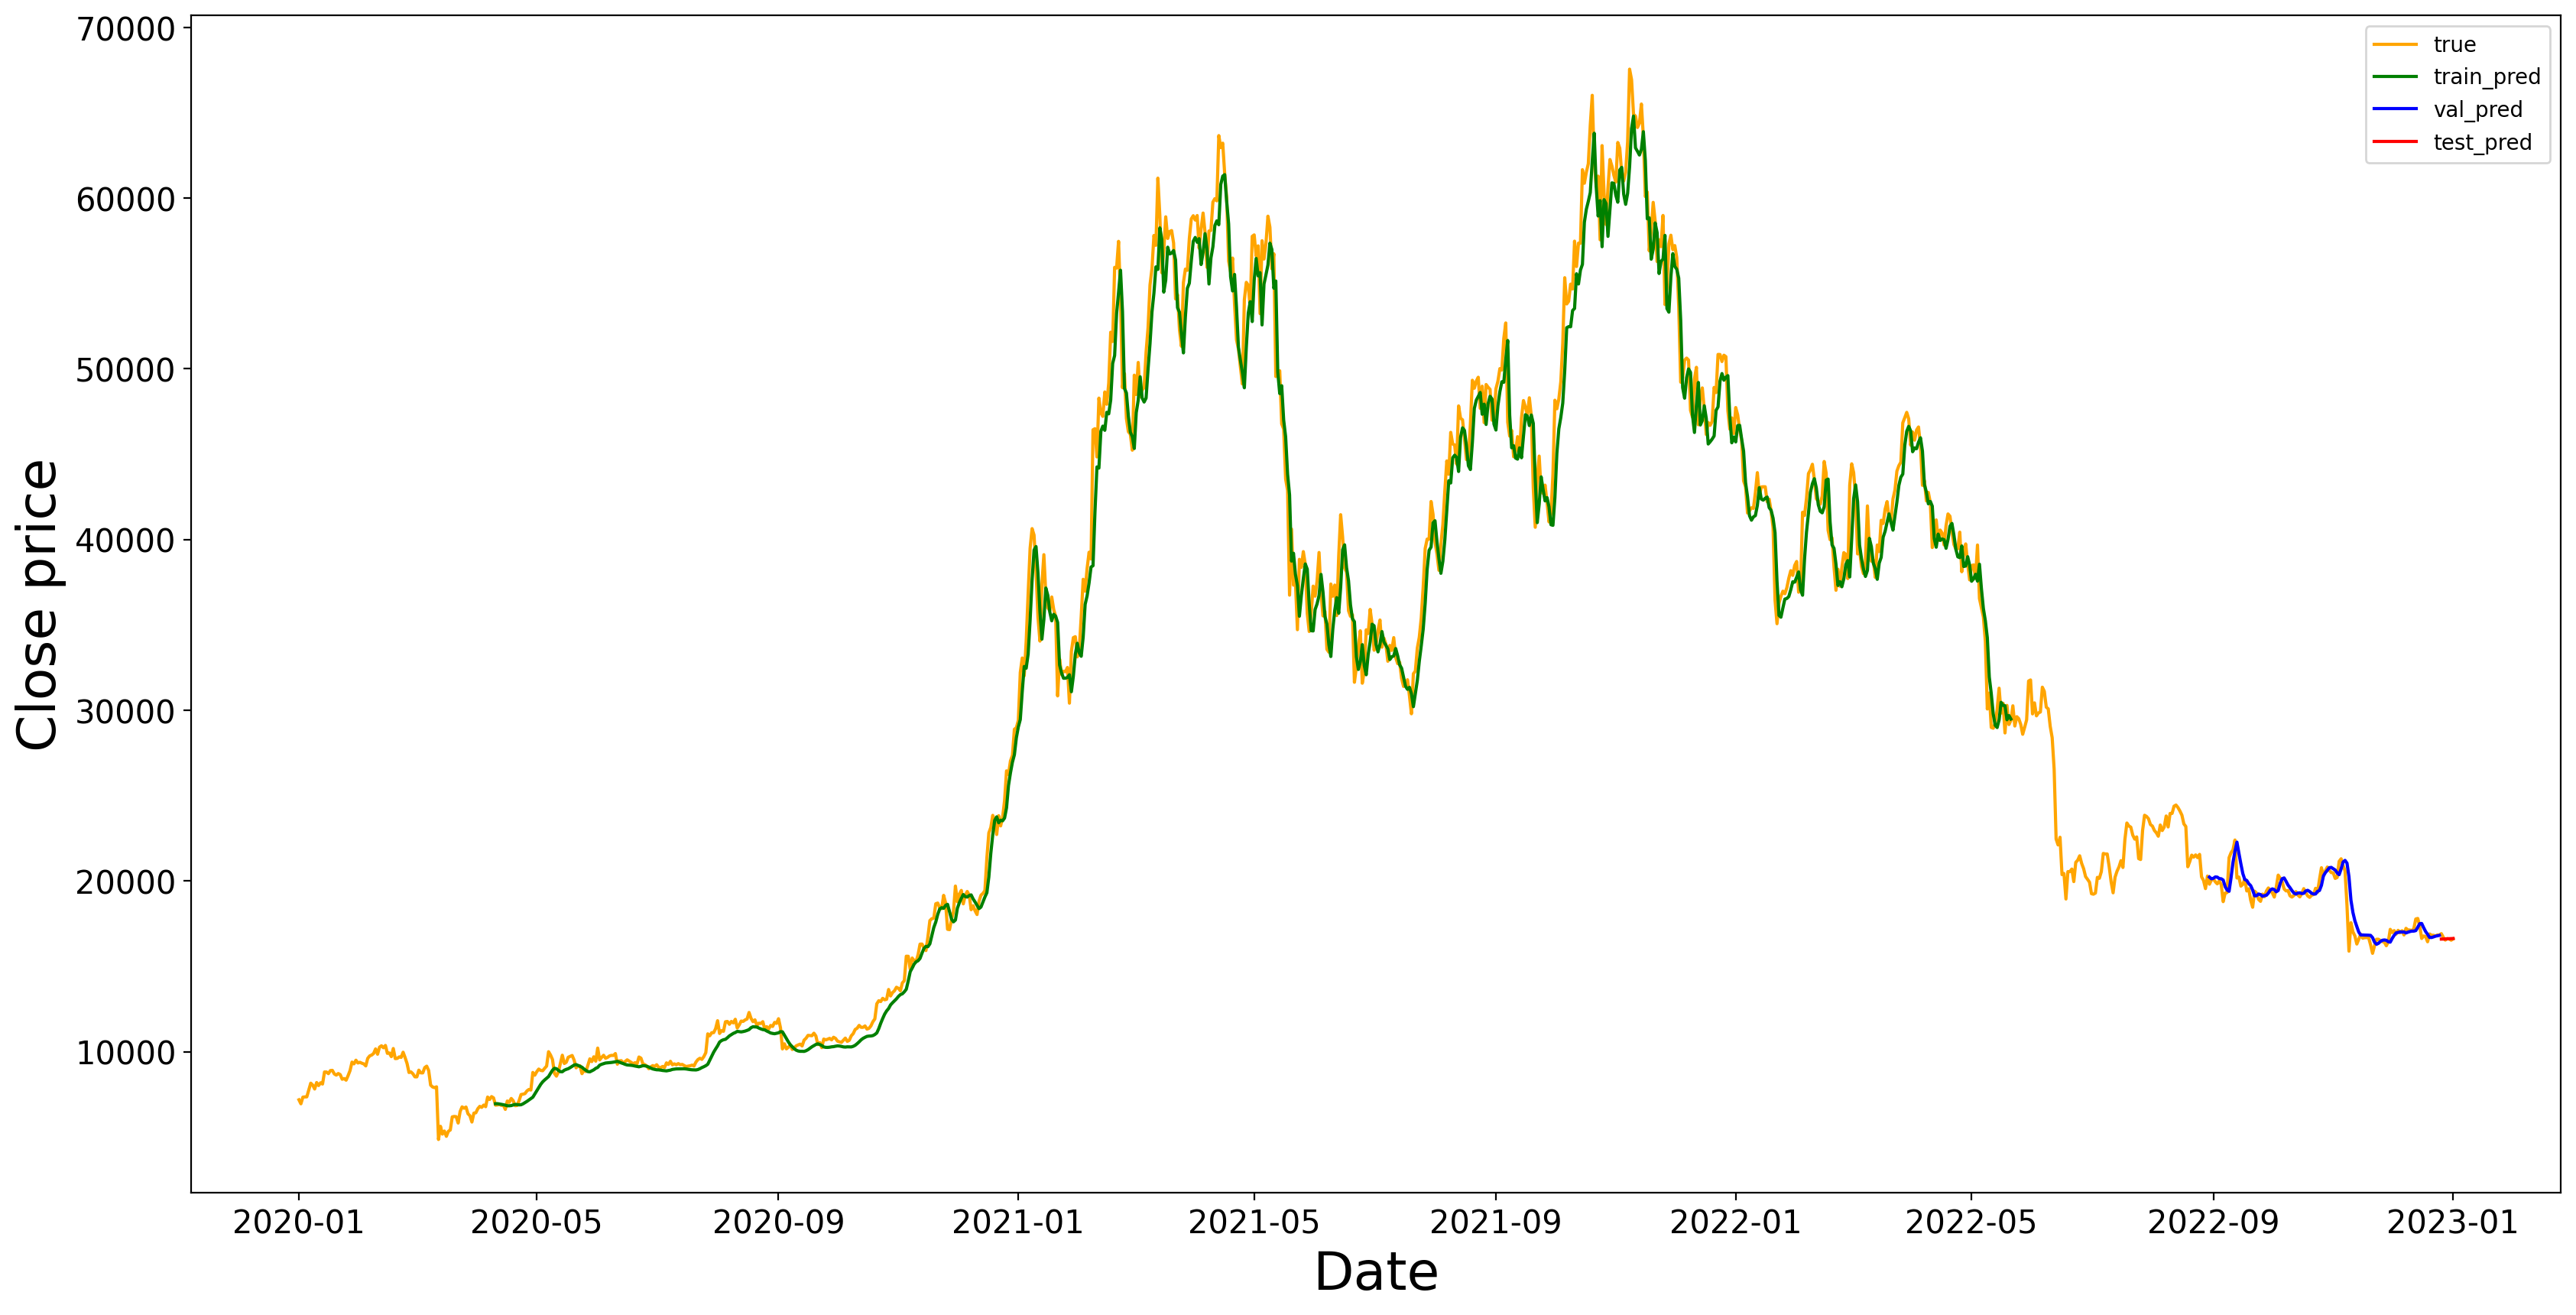

In [28]:
plt.plot(dates, close, color = 'orange', label = 'true')
plt.plot(dates[train_batch:train_batch+len(train_pred)], train_pred, color = 'green', label = 'train_pred')
plt.plot(dates[2*train_batch+len(train_pred):-period], val_pred, color = 'blue', label = 'val_pred')
plt.plot(dates[-period:], test_pred, color = 'red', label = 'test_pred')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

In [29]:
RMSE = mean_squared_error(test, test_pred, squared=False)
rel_error = ((
abs(test_pred - test)) / test) * 100

print("RMSE = %.3f" % RMSE, sep="")
print("Relative error = %.3f" % rel_error.mean(), '%', sep="")
print("Last relative error = %.3f" % rel_error[-1], '%', sep="")

RMSE = 134.119
Relative error = 0.537%
Last relative error = 0.109%


### Future prediction. ###

In [30]:
scaled_close = scaler.fit_transform(np.array(close).reshape(-1, 1))
X_train = scaled_close[-train_batch:].reshape(1, train_batch, 1)
future_pred = []
for i in range(period):
    next_pred = model.predict(X_train, verbose=0)
    X_train = X_train.reshape(X_train.shape[1])[1:]
    X_train = np.append(X_train, next_pred)
    X_train = X_train.reshape(1, train_batch, 1)
    future_pred.append(next_pred[0][0])

future_pred = scaler.inverse_transform(np.array(future_pred).reshape(-1, 1)).reshape(period)
future_pred

array([16598.418, 16600.406, 16606.014, 16612.535, 16618.877, 16624.58 ,
       16629.436], dtype=float32)

In [31]:
last_pred = future_pred[-1]
change_pred = (future_pred[-1] - close[-1]) / close[-1] * 100
print(f"Predicted price of {assets[0]} through {period} days = %.3f" % last_pred, sep="")
print(f"{assets[0]} change in percents = %.3f" % change_pred, '%', sep="")

Predicted price of bitcoin through 7 days = 16629.436
bitcoin change in percents = 0.109%
